## Application of Neural Networks to Flow Loop data stream

This code is based on the neural networks ipython notebook generated by KJ for the October, 2021 analysis of EPRI Flow Data. The version here is meant to process the flow loop data and look for the changes to the data stream produced by physical anomalies, as indicated by the notebook provided by Lea Boche and Christina Lawson (EPRI). This latest version accepts a pre-defined set of training and testing data (v1.2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 
import sys
sys.path.append('/Users/j.wagg/DataScience/S2DS/EPRI/NewData2022/Logs')
from lablog_parser import *
from custom_metric import *


pd.set_option("display.max.columns", None)

In [2]:
# reading in the flow loop data training sample 
flow_test = pd.read_csv("test_wternary.csv")
flow_train = pd.read_csv("train_wternary.csv")
flow_test.keys()

Index(['Unnamed: 0', 'max_FIT102_Raw_Signal', 'min_FIT102_Raw_Signal',
       'mean_FIT102_Raw_Signal', 'std_FIT102_Raw_Signal',
       'max_FIT202_Raw_Signal', 'min_FIT202_Raw_Signal',
       'mean_FIT202_Raw_Signal', 'std_FIT202_Raw_Signal',
       'max_LIT101_Raw_Signal', 'min_LIT101_Raw_Signal',
       'mean_LIT101_Raw_Signal', 'std_LIT101_Raw_Signal',
       'max_LIT201_Raw_Signal', 'min_LIT201_Raw_Signal',
       'mean_LIT201_Raw_Signal', 'std_LIT201_Raw_Signal',
       'max_PIT101_Raw_Signal', 'min_PIT101_Raw_Signal',
       'mean_PIT101_Raw_Signal', 'std_PIT101_Raw_Signal',
       'max_PIT102_Raw_Signal', 'min_PIT102_Raw_Signal',
       'mean_PIT102_Raw_Signal', 'std_PIT102_Raw_Signal',
       'max_PIT201_Raw_Signal', 'min_PIT201_Raw_Signal',
       'mean_PIT201_Raw_Signal', 'std_PIT201_Raw_Signal',
       'max_PIT202_Raw_Signal', 'min_PIT202_Raw_Signal',
       'mean_PIT202_Raw_Signal', 'std_PIT202_Raw_Signal',
       'max_SI102_Raw_Signal', 'min_SI102_Raw_Signal', 'mean_SI102

In [3]:
# add a columns to the data frame so that anomalies appear as binary 1 yes/0 no anomaly, or 0/1/2=cyber attack
# we can then use this for the Neural Network (just convert the 'label' column)
flow_test['tern_anomaly'] = 0
flow_train['tern_anomaly'] = 0
flow_test['bin_anomaly'] = 0
flow_train['bin_anomaly'] = 0

for index in flow_test.index:
    if flow_test['ternary'][index] == 'normal':
        flow_test.at[index,'tern_anomaly'] = 0
    if flow_test['ternary'][index] == 'mechanical':
        flow_test.at[index,'tern_anomaly'] = 1
    if flow_test['ternary'][index] == 'cyber':
        flow_test.at[index,'tern_anomaly'] = 2   
        
for index in flow_train.index:
    if flow_train['ternary'][index] == 'normal':
        flow_train.at[index,'tern_anomaly'] = 0
    if flow_train['ternary'][index] == 'mechanical':
        flow_train.at[index,'tern_anomaly'] = 1
    if flow_train['ternary'][index] == 'cyber':
        flow_train.at[index,'tern_anomaly'] = 2   

for index in flow_test.index:
    if flow_test['binary'][index] != 'normal':
        flow_test.at[index,'bin_anomaly'] = 1 

for index in flow_train.index:
    if flow_train['binary'][index] != 'normal':
        flow_train.at[index,'bin_anomaly'] = 1 

## Neural Network binary approach to classification of anomalies

In [4]:
# create a drop list, and you can alternatively swap 'tern_anomaly' with 'bin_anomaly' depending on your desired value
drop_list = ['Unnamed: 0','event','binary','ternary','tern_anomaly'] 

value = 'bin_anomaly'
print(flow_train['bin_anomaly'].describe())

count    11373.000000
mean         0.192034
std          0.393917
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: bin_anomaly, dtype: float64


   max_FIT102_Raw_Signal  min_FIT102_Raw_Signal  mean_FIT102_Raw_Signal  \
0                   4.30                  -4.28               -0.248235   
1                   4.58                  -3.32                0.001176   
2                   5.10                  -3.80                0.071765   
3                   5.10                  -3.80               -0.042353   
4                   5.10                  -3.80                0.175294   

   std_FIT102_Raw_Signal  max_FIT202_Raw_Signal  min_FIT202_Raw_Signal  \
0               2.485488                   2.68                  -4.32   
1               2.543123                   2.26                  -5.88   
2               2.814365                   5.16                  -5.88   
3               2.228765                   5.16                  -5.88   
4               2.095346                   2.74                  -3.54   

   mean_FIT202_Raw_Signal  std_FIT202_Raw_Signal  max_LIT101_Raw_Signal  \
0               -0.040000    

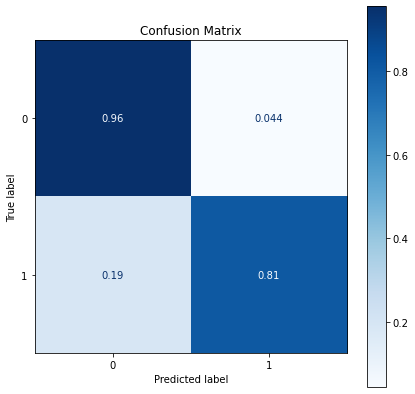

In [5]:
# Begin with binary classification approach

scaler = StandardScaler()  

#drop the columns we don't need
df1 = flow_train.drop(drop_list, axis=1)
df2 = flow_test.drop(drop_list, axis=1)

print(df1.head())
    
#define features and value
X = df1.drop(value, axis=1)
y = df1[value]

#create train and test datasets - note that from here will need to be updated as we are defining our own training sample 
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)
X_train = df1.drop(value, axis=1)
y_train = df1[value]
X_val = df2.drop(value, axis=1)
y_val = df2[value]

scaler.fit(X_train) 

X_train = scaler.transform(X_train)  
X_val = scaler.transform(X_val)
X = scaler.transform(X)


#train the model
model5 = MLPClassifier(random_state = 100, max_iter=1500)
    
model5.fit(X_train,y_train)
    
    
#calculate accuracy
predict_train = model5.predict(X_train)
predict_val = model5.predict(X_val)
accuracy_train = accuracy_score(y_train,predict_train)
print("Accuracies")
print('accuracy_score on train dataset : ', accuracy_train)
accuracy_val = accuracy_score(y_val,predict_val)
print('accuracy_score on test dataset : ', accuracy_val)
print('\n')
    
    
#print classification report
print('Classification report')
print(classification_report(y_val, predict_val))
print('\n')
    
#print normalized confusion matrix   
matrix = plot_confusion_matrix(model5, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
matrix.ax_.set_title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()


In [ ]:
#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

scores = cross_val_score(model5, X, y, cv=cv, n_jobs=-1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
print('\n')

scores = cross_val_score(model5, X, y, cv=cv, n_jobs=-1, scoring=make_scorer(cedric_metric_binary, greater_is_better=True))
print('Cross Validation custom metric scores: %s' % scores)
print('Cross Validation custom metric: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.93978022 0.93714286 0.94505495 0.94197802 0.93714286 0.94461538
 0.93582418 0.94021978 0.94857143 0.93934066]
Cross Validation accuracy: 0.941 +/- 0.004


